# Hindi Lexical Strata Analysis

I am applying [Rosen (2021)](https://scholarworks.umass.edu/scil/vol4/iss1/49/)'s model to Hindi. Some of this could go into a more final writeup. The basic idea of phontactic RNNs is to predict the next phoneme in a word given some context; more specifically, in this simple architecture, we want to minimise the overall phoneme perplexity in the set of words that we give for training.

Rosen (2021) extends this idea to unsupervised classification of lexical strata; since lexical strata in a language are governed by different phonotactic subgrammars (in the probabilistic sense, that is), if we simultaneously train two or more phonotactic RNNs on the set with appropriate loss function, we should be able to approximate those two phonotactic subgrammars. One lexical stratum will give overall lower perplexity in one model, etc.

The phonotactic data for Hindi used here is from the transliterations given in McGregor's [Oxford Hindi-English Dictionary](https://dsal.uchicago.edu/dictionaries/mcgregor/). Etymologies are also extracted from there. Unfortunately, University of Chicago (which hosts the dictionary) seems to have removed the proper transliterations and replaced them with an automatically generated version that ignores schwa deletion. Thankfully, I had scraped the transliterations before.

Hindi (at least in this dataset) has basically three large lexical strata. One is native vocabulary, which can be diachronically derived from Sanskrit undergoing regular sound changes. The other two are Sanskrit loans (used in the modern literary register and almost totally unmodified from Sanskrit phonotactics) and Perso-Arabic loans (Arabic loans in Hindi were mediated through Persian so we treat them as one class). Both borrowed strata are characterised by unique phonemes (Sanskrit /ʂ, ɳ, d͡ʒɲ/, Perso-Arabic /x, f, z, ʒ, ɣ/) and lots of clusters that are not present in the native stratum.

Hindi also might have old substrata of Munda and Dravidian which have assimilated to native phonotactics and whose size is not really agreed upon (some of the loans would have taken place at the Sanskrit stage itself) and a modern English stratum which isn't well-recorded in McGregor's dictionary and generally treated as part of codeswitched Hinglish rather than Hindi itself. There is also a small Portuguese stratum.

In [67]:
import csv
import matplotlib
import pandas as pd

In [4]:
translit = {}
with open('extra_large.csv', 'r') as translits:
    reader = csv.reader(translits)
    for row in reader:
        translit[row[1]] = row[0]

In [5]:
etym = {}
with open('mcgregor_etym.csv', 'r') as etyms:
    reader = csv.reader(etyms, delimiter='\t')
    for row in reader:
        etym[row[0]] = list(row[1].split(','))

In [6]:
translit['c i t k a b r aa']

'चितकबरा'

In [46]:
result = {}
with open('results2.txt', 'r') as results:
    reader = csv.reader(results, delimiter='\t')
    for row in reader:
        result[row[0]] = [float(x) for x in row[1:]]

# Two RNNs
Using Nelson and Mayer (2020)'s phonotactic model, we train two RNNs (initialised with random weights) to minimise average minimum (between the two) perplexity on the set of Hindi words. This partitions the words into two sets explained by two different phonotactic grammars, which might have some correspondence to lexical strata.

This is identical to what Rosen (2021) did on Japanese, the model architecture is nothing new so this is hardly enough for the paper, but a good start. I just modified some of his code to make the output easier to analyse.

In [92]:
pa = []
sa = []
na = []
drav = []
none = []
en = []
for i in result:
    if i not in translit: continue
    if translit[i] not in etym: continue
    if etym[translit[i]] == ['Perso-Arabic']: pa.append(result[i])
    if etym[translit[i]] == ['Sanskrit']: sa.append(result[i])
    if etym[translit[i]] == ['Native']: na.append(result[i])
    if etym[translit[i]] == ['Dravidian']: drav.append(result[i])
    if etym[translit[i]] == ['']: none.append(result[i])
    if etym[translit[i]] == ['English']: en.append(result[i])
pa[:5]

[[27.29681, 12.037943],
 [14.046133, 11.192161],
 [6.510639, 8.945362],
 [11.68725, 7.8056884],
 [8.044327, 6.2535715]]

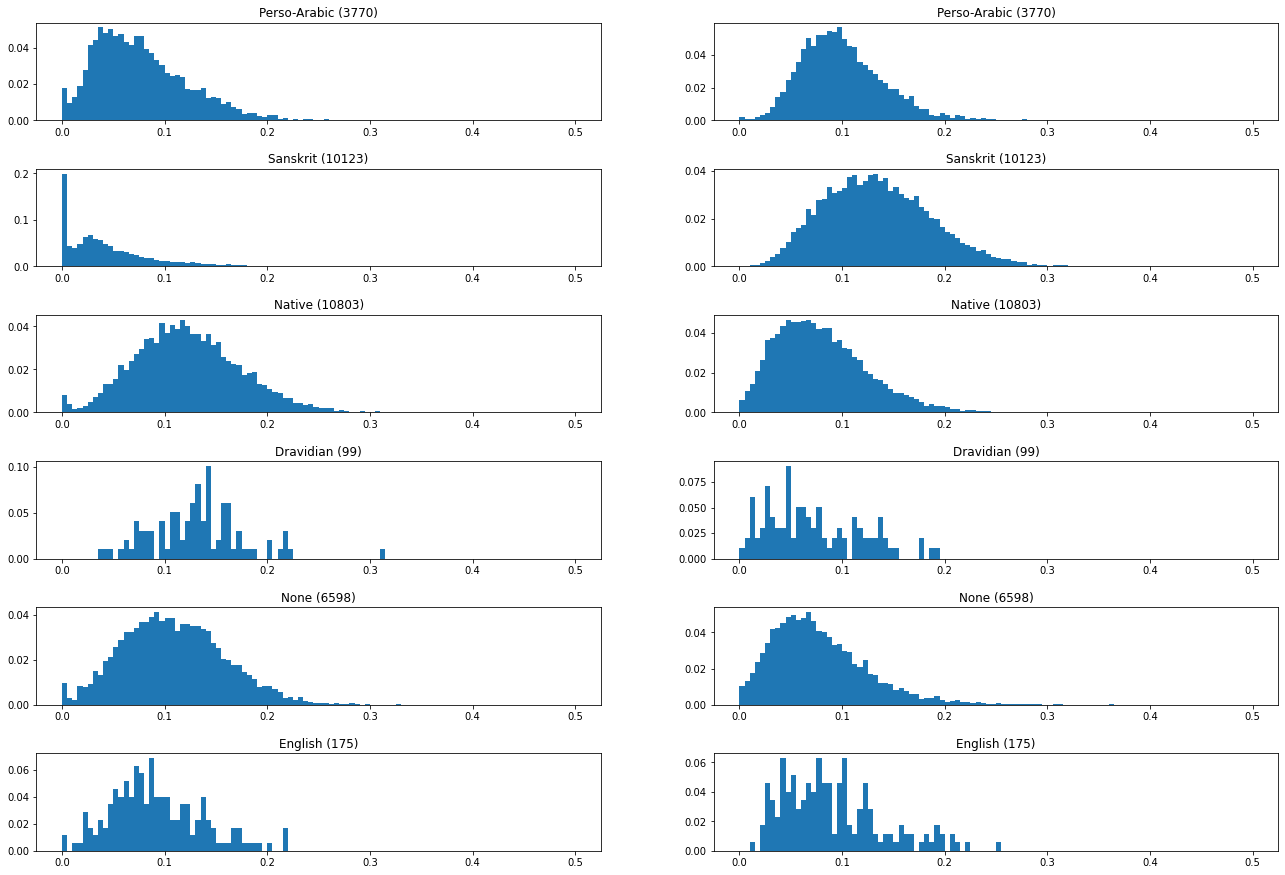

In [93]:
import matplotlib.pyplot as plt
import math
import numpy as np

data = [pa, sa, na, drav, none, en]
labels = ['Perso-Arabic', 'Sanskrit', 'Native', 'Dravidian', 'None', 'English']

fig, ax = plt.subplots(len(data), 2)
for j in range(2):
    for i, d in enumerate(data):
        ax[i][j].hist([1 / x[j] for x in d], bins=100, range=(0, 0.5), weights=np.ones(len(d)) / len(d))
        ax[i][j].title.set_text(f'{labels[i]} ({len(d)})')
    
plt.subplots_adjust(top=3, right=3, hspace=0.5)
plt.show()

## Analysis
The plots above show the distribution of inverse of perplexity for every word in the Hindi set. Etymologies are extracted from the McGregor dictionary for as many words as possible. You can see that RNN 0 (left column) is optimised for native words (lowest perplexity) and gives very high perplexity for Sanskrit words especiially. RNN 1 (right column) is optimised for Sanskrit and, to some extent, Perso-Arabic loans.

I've also graphed English, Dravidian, and "None" (McGregor lists no etymology, these are either native synchronic derivations or words with unknown, deśī, etymologies like onomatopoeia or potentially assimilated substrata).

Percent of words with lower perplexity in Model X (column):

| | Model 0 ("Native") | Model 1 ("Loan") | Total |
| ---- | ---- | ---- | ---- |
| Perso-Arabic | 28.7% | **71.3%** | 100% |
| Sanskrit | 8.5% | **91.5%** | 100% |
| Native | **76.9%** | 23.1% | 100% |

An interesting thing about Model 0 (the "Native" phonotactic grammar): it gives extremely large perplexities for Sanskrit words, but Model 1 (the "Sanskritised" phonotactic grammar) doesn't give very large perplexities for native words. I think this shows that the phontactics of Model 0 are nearly a subset of those of Model 1, i.e. many native Hindi words violate less of the Sanskritised phonotactics than the other way.

It's also telling that Perso-Arabic loans typify with Sanskrit. I'd have expected them to typify with native words since they seem to be quite easy to integrate into native phonotactics, besides some weird clusters and new sounds (e.g. /x/) that don't exist natively. Need to find linguistic literature on this to inform some model probing.

Some things to investigate: does Model 1 penalise consecutive vowels (allowed in native Hindi but not in Sanskrit)? What about the retroflex flap (nonexistent in Sanskrit)? And what sequences does Model 0 penalise?

In [70]:
print('AVERAGES')
print('Perso-Arabic', sum([x[0] - x[1] for x in pa]) / len(pa))
print('Sanskrit', sum([x[0] - x[1] for x in sa]) / len(sa))
print('Native', sum([x[0] - x[1] for x in na]) / len(na))
print('\nAVERAGES (0)')
print('Perso-Arabic', sum([x[0] for x in pa]) / len(pa))
print('Sanskrit', sum([x[0] for x in sa]) / len(sa))
print('Native', sum([x[0] for x in na]) / len(na))
print('\nAVERAGES (1)')
print('Perso-Arabic', sum([x[1] for x in pa]) / len(pa))
print('Sanskrit', sum([x[1] for x in sa]) / len(sa))
print('Native', sum([x[1] for x in na]) / len(na))

AVERAGES
Perso-Arabic 18.34046526124668
Sanskrit 211.27375067708215
Native -8.47893741843004

AVERAGES (0)
Perso-Arabic 31.48237230236074
Sanskrit 220.33373953644207
Native 14.607080581412514

AVERAGES (1)
Perso-Arabic 13.141907041114061
Sanskrit 9.059988859359885
Native 23.086017999842735


In [77]:
print('COUNT > 0')
print('Perso-Arabic', len([1 for x in pa if x[0] > x[1]]) / len(pa))
print('Sanskrit', len([1 for x in sa if x[0] > x[1]]) / len(sa))
print('Native', len([1 for x in na if x[0] > x[1]]) / len(na))
print('Dravidian', len([1 for x in drav if x[0] > x[1]]) / len(drav))
print('None', len([1 for x in none if x[0] > x[1]]) / len(none))
print('English', len([1 for x in en if x[0] > x[1]]) / len(en))

COUNT > 0
Perso-Arabic 0.7129973474801061
Sanskrit 0.9145510224241825
Native 0.2313246320466537
Dravidian 0.1717171717171717
None 0.2859957562897848
English 0.48


# Three RNNs
Can we extend Rosen (2021)'s approach to a greater number of phonotactic grammars (3 in this case)? Will we be able to separate out Perso-Arabic as a distinct lexical stratum in Hindi?

It seems we can, kind of. There is a lot of bleed-through of the native vocabulary into the other strata.

| | Model 0 | Model 1 | Model 2 | Total |
| ---- | ---- | ---- | ---- | ---- |
| Perso-Arabic | 12.9% | **71.3%** | 14.1% | 100% |
| Sanskrit | 5.3% | 14.1% | **80.5%** | 100% |
| Native | **58.3%** | 27.9% | 13.8% | 100% |

In [80]:
result3 = {}
with open('results3.txt', 'r') as results3:
    reader = csv.reader(results3, delimiter='\t')
    for row in reader:
        result3[row[0]] = [float(x) for x in row[1:]]

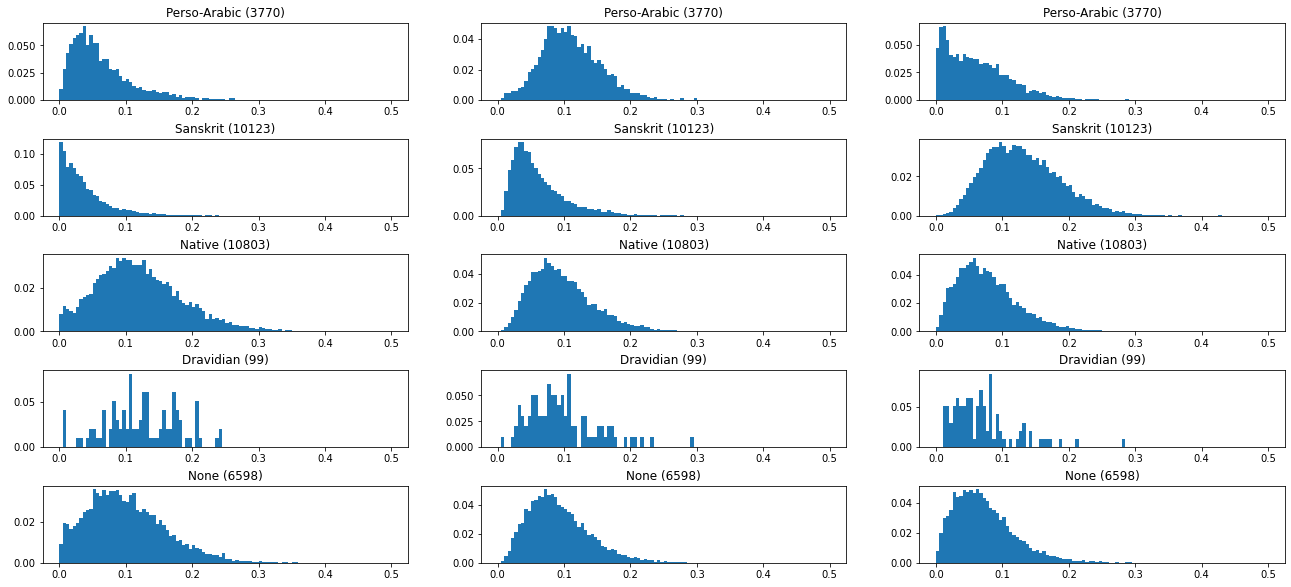

In [81]:
pa = []
sa = []
na = []
drav = []
none = []
for i in result:
    if i not in translit: continue
    if translit[i] not in etym: continue
    if etym[translit[i]] == ['Perso-Arabic']: pa.append(result3[i])
    if etym[translit[i]] == ['Sanskrit']: sa.append(result3[i])
    if etym[translit[i]] == ['Native']: na.append(result3[i])
    if etym[translit[i]] == ['Dravidian']: drav.append(result3[i])
    if etym[translit[i]] == ['']: none.append(result3[i])

data = [pa, sa, na, drav, none]
labels = ['Perso-Arabic', 'Sanskrit', 'Native', 'Dravidian', 'None']

fig, ax = plt.subplots(len(data), 3)
for j in range(3):
    for i, d in enumerate(data):
        ax[i][j].hist([1 / x[j] for x in d], bins=100, range=(0, 0.5), weights=np.ones(len(d)) / len(d))
        ax[i][j].title.set_text(f'{labels[i]} ({len(d)})')
    
plt.subplots_adjust(top=2, right=3, hspace=0.5)
plt.show()

In [82]:
print('AVERAGES')
print('Perso-Arabic', sum([x[0] - x[1] for x in pa]) / len(pa))
print('Sanskrit', sum([x[0] - x[1] for x in sa]) / len(sa))
print('Native', sum([x[0] - x[1] for x in na]) / len(na))
print('\nAVERAGES (0)')
print('Perso-Arabic', sum([x[0] for x in pa]) / len(pa))
print('Sanskrit', sum([x[0] for x in sa]) / len(sa))
print('Native', sum([x[0] for x in na]) / len(na))
print('\nAVERAGES (1)')
print('Perso-Arabic', sum([x[1] for x in pa]) / len(pa))
print('Sanskrit', sum([x[1] for x in sa]) / len(sa))
print('Native', sum([x[1] for x in na]) / len(na))
print('\nAVERAGES (2)')
print('Perso-Arabic', sum([x[2] for x in pa]) / len(pa))
print('Sanskrit', sum([x[2] for x in sa]) / len(sa))
print('Native', sum([x[2] for x in na]) / len(na))

AVERAGES
Perso-Arabic 19.245452573580895
Sanskrit 72.39254217637072
Native 2.803343976571314

AVERAGES (0)
Perso-Arabic 30.741789289336882
Sanskrit 96.80739044872064
Native 16.401957265953975

AVERAGES (1)
Perso-Arabic 11.49633671575598
Sanskrit 24.414848272350017
Native 13.598613289382556

AVERAGES (2)
Perso-Arabic 56.44666871835532
Sanskrit 9.603860960565033
Native 20.92610165859484


In [90]:
from numpy import argmin

for i, lang in enumerate(data):
    print(labels[i], end='\t')
    for j in range(3):
        print(len([1 for x in lang if argmin(x) == j]) / len(lang), end='\t\t')
    print()

Perso-Arabic	0.1286472148541114		0.7302387267904509		0.14111405835543767		
Sanskrit	0.05344265533932629		0.14106490170897956		0.8054924429516942		
Native	0.583171341294085		0.27862630750717393		0.13820235119874108		
Dravidian	0.6565656565656566		0.26262626262626265		0.08080808080808081		
None	0.48605638072143076		0.3423764777205214		0.1715671415580479		
